In [36]:
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import functools
import jax
import os
import pandas as pd
import mlflow
import pickle

from datetime import datetime
from jax import numpy as jnp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output
import mediapy

import brax

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

# other envs
from task_aware_skill_composition.brax.envs.point import Point
from task_aware_skill_composition.brax.envs.car import Car
from task_aware_skill_composition.brax.envs.drone import Drone
from task_aware_skill_composition.brax.envs.point import Point
from task_aware_skill_composition.brax.envs.doggo import Doggo
from task_aware_skill_composition.brax.envs.xy_point_maze import XYPointMaze

# tasks
from task_aware_skill_composition.brax.tasks import get_task

mlflow.set_tracking_uri(f"file:///home/tassos/.local/share/mlflow")

# Defining STL

In [38]:
# import corallab_stl.expression_jax2 as stl
# import corallab_stl.expression_jax2_extra as stl_extra

# state_var = stl.Var("state", idx=0, dim=37, y_velocity=14)
# # moderate_y_vel = stl_extra.InBox(state_var.y_velocity, jnp.array([0.4]), jnp.array([25.0]))
# # always_moderate_y_vel = stl.STLUntimedAlways(moderate_y_vel)
# # eventually_always_moderate_y_vel = stl.STLUntimedEventually(always_moderate_y_vel)

# true = stl.STLPredicate(state_var, lambda s: 999, lower_bound=0.0)

# high_y_vel = stl.STLPredicate(state_var.y_velocity, lambda s: s[0], lower_bound=1.0)
# always_high_y_vel = stl.STLUntimedAlways(high_y_vel)
# eventually_high_y_vel = stl.STLUntimedEventually(high_y_vel)
# eventually_always_high_y_vel = stl.STLUntimedEventually(always_high_y_vel)

# state_var = stl.Var("state", idx=0, dim=29, position=(0, 2))

# def in_box_pred(x_min, x_max):
#     dim = x_min.shape[0]
#     neg_eye = -jnp.eye(dim)
#     pos_eye = jnp.eye(dim)
#     A = jnp.vstack((neg_eye, pos_eye))
#     b = jnp.concatenate((-x_min, x_max))
        
#     def in_box(s):
#         x = b - jnp.matmul(A, s)
#         return jnp.min(x, axis=-1)

#     return in_box

# in_region_1 = stl.STLPredicate(
#     state_var.position,
#     in_box_pred(jnp.array([3.0, 3.0]), jnp.array([4.0, 4.0])),
#     0.1
# )

# in_region_2 = stl.STLPredicate(
#     state_var.position,
#     in_box_pred(jnp.array([-4.0, 3.0]), jnp.array([-3.0, 4.0])),
#     0.1
# )

# in_region_3 = stl.STLPredicate(
#     state_var.position,
#     in_box_pred(jnp.array([1.5, 1.5]), jnp.array([2.5, 2.5])),
#     0.0
# )

# phi = stl.STLAnd(
#     stl.STLUntimedEventually(
#         stl.STLAnd(
#             in_region_1,
#             stl.STLNext(stl.STLUntimedEventually(in_region_2)),
#         )
#     ),
#     stl.STLUntimedAlways(stl.STLNegation(in_region_3))
# )

# phi({ state_var.idx: jnp.array([[0.0, 0.0],
#                                 [3.0, 0.0],
#                                 [3.5, 3.0],
#                                 [3.5, 3.5],
#                                 [-3.5, 3.5]]) })

# in_region_1 = stl.STLPredicate(state_var.position, lambda s: s

# high_y_vel = stl.STLPredicate(state_var.y_velocity, lambda s: s[0], lower_bound=1.0)
# always_high_y_vel = stl.STLUntimedAlways(high_y_vel)
# eventually_always_high_y_vel = stl.STLUntimedEventually(high_y_vel)

# Defining Env/Task

In [39]:
mlflow.set_experiment("proj2-hierarchy-comparison")

<Experiment: artifact_location='file:///home/tassos/.local/share/mlflow/778019973331947620', creation_time=1731686379807, experiment_id='778019973331947620', last_update_time=1731686379807, lifecycle_stage='active', name='proj2-hierarchy-comparison', tags={}>

In [40]:
backend = 'mjx'

# env = Car(backend=backend)
# env = Drone(backend=backend)
# env = Point(backend=backend)
# env = Doggo(backend=backend)

# env = envs.get_environment(env_name="reacher", backend=backend)
# env = AntMaze(backend=backend)

# task = get_task("point", "one_goal")

# task = get_task("xy_point_maze", "true")
# task = get_task("ant_maze", "true")
# task = get_task("simple_maze", "true")
task = get_task("xy_point", "turn_seq")
# task = get_task("xy_point", "straight")
# task = get_task("ant", "straight_seq")
env = task.env

spec = task.lo_spec
spec_tag = type(task).__name__
env_tag = type(env).__name__

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [41]:
print(spec_tag)
print(spec)
print(env.observation_size)
print(env.action_size)
alg_suffix = ""

XYPointTurnSequence
4
2


## Making the Env Automaton Wrapped

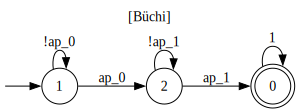

In [42]:
from task_aware_skill_composition.brax.envs.wrappers.automaton_wrapper import AutomatonWrapper

automaton_wrapped_env = AutomatonWrapper(
    env,
    spec,
    task.obs_var,
    augment_obs = True
)

alg_suffix = "_with_aut0"
# env = automaton_wrapped_env

automaton_wrapped_env.automaton.automaton

In [43]:
print(automaton_wrapped_env.observation_size)
print(automaton_wrapped_env.action_size)
alg_suffix = ""

7
2


# Plotting Utils

In [44]:
# xdata, ydata = [], []
# times = [datetime.now()]

def progress_fn(num_steps, metrics, df=None):
    print(f"Logging for {num_steps}")
    mlflow.log_metrics(metrics, step=num_steps)
    
    # df.loc[num_steps] = {
    #     "time": datetime.now(),
    #     "eval/episode_reward": metrics['eval/episode_reward'],
    #     "eval/episode_robustness": metrics['eval/episode_robustness'] if 'eval/episode_robustness' in metrics else None, 
    #     "training/specification_loss": metrics['training/specification_loss'] if 'training/specification_loss' in metrics else None, 
    # }

# Training

In [47]:
from task_aware_skill_composition.brax.agents.ppo import train as ppo
from task_aware_skill_composition.brax.agents.sac import train as sac
from task_aware_skill_composition.brax.agents.dscrl import train as dscrl
from task_aware_skill_composition.brax.agents.ppo_with_spec_rewards import train as ppo_spec

def training_run(run_id, env, seed, train_fn=ppo.train, hyperparameters={}, extras={}):
    hyperparameters = {
        **hyperparameters,
        "seed": seed,
    }

    mlflow.log_params(hyperparameters)

    train_fn = functools.partial(train_fn, **hyperparameters)
    
    make_inference_fn, params, _ = train_fn(
        environment=env,
        progress_fn=functools.partial(progress_fn),
        seed=seed,
        **extras
    )

    with mlflow.MlflowClient()._log_artifact_helper(run_id, f'policy_params') as tmp_path:
        model.save_params(tmp_path, params)

    return make_inference_fn, params

## Training Policy with PPO

In [35]:
for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": "PPO"}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=ppo.train,
            hyperparameters=task.ppo_hps,
            extras={
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 5570560
Logging for 11141120
Logging for 16711680
Logging for 22282240
Logging for 27852800
Logging for 33423360
Logging for 38993920
Logging for 44564480
Logging for 50135040
Logging for 0
Logging for 5570560
Logging for 11141120
Logging for 16711680
Logging for 22282240
Logging for 27852800
Logging for 33423360
Logging for 38993920
Logging for 44564480
Logging for 50135040
Logging for 0
Logging for 5570560
Logging for 11141120
Logging for 16711680
Logging for 22282240
Logging for 27852800
Logging for 33423360
Logging for 38993920
Logging for 44564480
Logging for 50135040


## Training with Hierarchical PPO

In [36]:
from task_aware_skill_composition.brax.agents.ppo_option_critic import train as ppo_option_critic
from task_aware_skill_composition.hierarchy.state import OptionState

In [37]:
from task_aware_skill_composition.hierarchy.xy_point.load import load_xy_point_options, load_hard_coded_xy_point_options

# def adapter(x):
#     return x[..., :-2]

options = load_hard_coded_xy_point_options()
# options = load_xy_point_options() # adapter=adapter)

up [0. 1.]
right [1. 0.]
left [-1.  0.]
down [ 0. -1.]


In [38]:
# mlflow.set_experiment("proj2-hierarchical-ppo")

for seed in range(0, 3):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": "H_PPO"}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=ppo_option_critic.train,
            hyperparameters=task.hppo_hps,
            extras={
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 5570560
Logging for 11141120
Logging for 16711680
Logging for 22282240
Logging for 27852800
Logging for 33423360
Logging for 38993920
Logging for 44564480
Logging for 50135040
Logging for 0
Logging for 5570560
Logging for 11141120
Logging for 16711680
Logging for 22282240
Logging for 27852800
Logging for 33423360
Logging for 38993920
Logging for 44564480
Logging for 50135040
Logging for 0
Logging for 5570560
Logging for 11141120
Logging for 16711680
Logging for 22282240
Logging for 27852800
Logging for 33423360
Logging for 38993920
Logging for 44564480
Logging for 50135040


## Training with SAC+HER (from JaxGCRL)

In [48]:
# sac_hps = {
#     "num_timesteps": 10_000_000,
#     "reward_scaling": 1,
#     "num_evals": 50,
#     "episode_length": 1000,
#     "normalize_observations": True,
#     "action_repeat": 1,
#     "discounting": 0.99,
#     # "learning_rate": 3e-4,
#     "num_envs": 512,
#     "batch_size": 256,
#     "unroll_length": 62,
#     "multiplier_num_sgd_steps": 1,
#     "max_devices_per_host": 1,
#     "max_replay_size": 10000,
#     # 8192, the default, causes the error "TypeError: broadcast_in_dim shape must have every element be nonnegative, got (-2, 50)."
#     "min_replay_size": 1000,
#     "use_her": True,
# }

In [ ]:
# mlflow.set_experiment("proj2-sac-her")

alg_tag = "SAC" + alg_suffix

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            automaton_wrapped_env,
            seed,
            train_fn=sac.train,
            hyperparameters=task.sac_hps,
            extras={
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Num_prefill_actor_steps:  17


NameError: name 'specification' is not defined

## Training with Hierarchical SAC+HER

In [58]:
from task_aware_skill_composition.brax.agents.sac_option_critic import train as hsac

In [59]:
# hsac_hps = {
#     "num_timesteps": 10_000_000,
#     "reward_scaling": 1,
#     "num_evals": 50,
#     "episode_length": 1000,
#     "normalize_observations": True,
#     "action_repeat": 1,
#     "discounting": 0.99,
#     # "learning_rate": 3e-4,
#     "num_envs": 256,
#     "batch_size": 256,
#     "unroll_length": 62,
#     "multiplier_num_sgd_steps": 1,
#     "max_devices_per_host": 1,
#     "max_replay_size": 10000,
#     # 8192, the default, causes the error "TypeError: broadcast_in_dim shape must have every element be nonnegative, got (-2, 50)."
#     "min_replay_size": 1000,
#     "use_her": True,
# }

In [60]:
from task_aware_skill_composition.hierarchy.xy_point.load import load_xy_point_options, load_hard_coded_xy_point_options
from task_aware_skill_composition.hierarchy.ant.load import load_ant_options

# def adapter(x):
#     return x[..., 2:-2]

options = load_hard_coded_xy_point_options()
# options = load_ant_options(adapter=adapter)
# options = load_xy_point_options() # adapter=adapter)

up [0. 1.]
right [1. 0.]
left [-1.  0.]
down [ 0. -1.]


In [62]:
%%notify

alg_tag = "H_SAC" + alg_suffix

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=hsac.train,
            hyperparameters=task.hsac_hps,
            extras={
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Num_prefill_actor_steps:  17


TypeError: sub got incompatible shapes for broadcasting: (16,), (4,).

<IPython.core.display.Javascript object>

## Training Policy with PPO + STL Rewards

In [12]:
from task_aware_skill_composition.brax.envs.wrappers.specification_reward_wrapper import SpecificationRewardWrapper

In [15]:
# mlflow.set_experiment("proj2-ppo-spec")

spec_wrapped_env = SpecificationRewardWrapper(
    env,
    spec,
    task.obs_var,
    rho_weight=1.0
)

for seed in range(0, 3):
    with mlflow.start_run(tags={"alg": "ppo_spec", "env": env_tag, "spec": spec_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            spec_wrapped_env,
            seed,
            train_fn=ppo.train,
            hyperparameters={**task.ppo_hps, "num_timesteps": 10_000_000},
            extras={
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 655360
Logging for 1310720
Logging for 1966080
Logging for 2621440
Logging for 3276800
Logging for 3932160
Logging for 4587520
Logging for 5242880
Logging for 5898240
Logging for 6553600
Logging for 7208960
Logging for 7864320
Logging for 8519680
Logging for 9175040
Logging for 9830400
Logging for 10485760
Logging for 11141120
Logging for 11796480
Logging for 11141120
Logging for 11796480
Logging for 12451840
Logging for 0
Logging for 4587520
Logging for 10485760
Logging for 11141120
Logging for 11796480
Logging for 12451840


## Training Policy with PPO + Automaton State

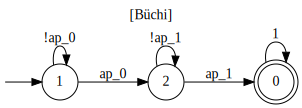

In [80]:
normalization_mask = jnp.array([1] * task.obs_var.dim + [0] * automaton_wrapped_env.automaton.n_states, dtype=jnp.uint8)

In [81]:
mlflow.set_experiment("proj2-ppo-automaton")

for seed in range(0, 3):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            automaton_wrapped_env,
            seed,
            train_fn=ppo.train,
            hyperparameters={**task.ppo_hps, "num_timesteps": 50_000_000},
            extras={
                "normalization_mask": normalization_mask,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 2949120
Logging for 5898240
Logging for 8847360
Logging for 11796480
Logging for 14745600
Logging for 17694720
Logging for 20643840
Logging for 23592960
Logging for 26542080
Logging for 29491200
Logging for 32440320
Logging for 35389440
Logging for 38338560
Logging for 41287680
Logging for 44236800
Logging for 47185920
Logging for 50135040
Logging for 53084160
Logging for 56033280


## Training with PPO + Automaton Transition Rewards

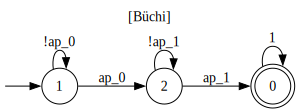

In [44]:
from task_aware_skill_composition.brax.envs.wrappers.automaton_wrapper import AutomatonWrapper
from task_aware_skill_composition.brax.envs.wrappers.automaton_transition_rewards_wrapper import AutomatonTransitionRewardsWrapper

automaton_wrapped_env = AutomatonWrapper(
    env,
    spec,
    task.obs_var,
    augment_obs = True
)

automaton_wrapped_env = AutomatonTransitionRewardsWrapper(
    automaton_wrapped_env
)

automaton_wrapped_env.automaton.automaton

In [ ]:
mlflow.set_experiment("proj2-ppo-automaton-rewards")

for seed in range(1, 3):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            automaton_wrapped_env,
            seed,
            train_fn=ppo.train,
            hyperparameters={**task.ppo_hps, num_timesteps=10_000_000},
            extras={
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 10813440
Logging for 21626880
Logging for 32440320
Logging for 43253760
Logging for 54067200
Logging for 64880640
Logging for 75694080
Logging for 86507520
Logging for 97320960
Logging for 108134400
Logging for 118947840
Logging for 129761280
Logging for 140574720
Logging for 151388160
Logging for 162201600
Logging for 173015040
Logging for 183828480
Logging for 194641920
Logging for 205455360
Logging for 0
Logging for 10813440
Logging for 21626880
Logging for 32440320
Logging for 43253760
Logging for 54067200
Logging for 64880640
Logging for 75694080
Logging for 86507520
Logging for 97320960
Logging for 108134400
Logging for 118947840
Logging for 129761280
Logging for 140574720
Logging for 151388160
Logging for 162201600
Logging for 173015040
Logging for 183828480
Logging for 194641920
Logging for 205455360


## Training with CRL

In [11]:
crl_hps = {
    "num_timesteps": 10_000_000,
    "max_replay_size": 10_000,
    "min_replay_size": 1_000,
    "num_evals": 50,
    "episode_length": 1000,
    "action_repeat": 1,
    "discounting": 0.99,
    "num_envs": 512,
    "batch_size": 256,
    "unroll_length": 62,
    "multiplier_num_sgd_steps": 1,
    # "env_name": "reacher",
    "normalize_observations": False,
    "policy_lr": 6e-4,
    "alpha_lr": 3e-4,
    "critic_lr": 3e-4,
    "contrastive_loss_fn": 'infonce_backward',
    "energy_fn": 'l2',
    # "backend": None,
    # "no_resubs": False,
    "use_ln": False,
    "use_c_target": False,
    "logsumexp_penalty": 0.0,
    "l2_penalty": 0.0,
    "exploration_coef": 0.0,
    "random_goals": 0.0,
    # "log_wandb": False,
    "disable_entropy_actor": False,
    "eval_env": None,
    "h_dim": 256,
    "n_hidden": 2,
    "repr_dim": 64,
}

In [12]:
from jaxgcrl import train as crl

In [13]:
for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": "CRL"}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=crl.train,
            hyperparameters=crl_hps,
            # extras={
            #     "specification": spec,
            #     "state_var": task.obs_var,
            # }
        )

Num_prefill_actor_steps:  17
Logging for 0
Logging for 761856
Logging for 984064
Logging for 1206272
Logging for 1428480
Logging for 1650688
Logging for 1872896
Logging for 2095104
Logging for 2317312
Logging for 2539520
Logging for 2761728
Logging for 2983936
Logging for 3206144
Logging for 3428352
Logging for 3650560
Logging for 3872768
Logging for 4094976
Logging for 4317184
Logging for 4539392
Logging for 4761600
Logging for 4983808
Logging for 5206016
Logging for 5428224
Logging for 5650432
Logging for 5872640
Logging for 6094848
Logging for 6317056
Logging for 6539264
Logging for 6761472
Logging for 6983680
Logging for 7205888
Logging for 7428096
Logging for 7650304
Logging for 7872512
Logging for 8094720
Logging for 8316928
Logging for 8539136
Logging for 8761344
Logging for 8983552
Logging for 9205760
Logging for 9427968
Logging for 9650176
Logging for 9872384
Logging for 10094592
Logging for 10316800
Logging for 10539008
Logging for 10761216
Logging for 10983424
Logging for 11

# Visualizing Policy

In [27]:
# If using a policy considering the automaton
env = automaton_wrapped_env

## Loading from a previous run

In [39]:
from brax.training.agents.ppo import networks as ppo_networks
from task_aware_skill_composition.hierarchy.option_critic import networks as oc_networks
from task_aware_skill_composition.brax.agents.sac_option_critic import networks as hsac_networks
from jaxgcrl.src import networks as crl_networks
from brax.training.acme import running_statistics

In [77]:
training_run_id = "7dc22a69a5e24fba82b21604a20c3006"
logged_model_path = f'runs:/{training_run_id}/policy_params'
real_path = mlflow.artifacts.download_artifacts(logged_model_path)
params = model.load_params(real_path)
# normalizer_params, policy_params = model.load_params(real_path)
# normalizer_params, policy_params, crl_critic_params = model.load_params(real_path)

In [78]:
run = mlflow.get_run(run_id=training_run_id)
if run.data.params["normalize_observations"] == "True":
    normalize = running_statistics.normalize
else:
    normalize = lambda x, y: x

In [96]:
# # Making the network
# ppo_network = ppo_networks.make_ppo_networks(
#       state.obs.shape[0],
#       env.action_size,
#       preprocess_observations_fn=normalize
# )
# make_policy = ppo_networks.make_inference_fn(ppo_network)

# # Making the network
# oc_network = oc_networks.make_option_critic_networks(
#       state.obs.shape[0],
#       env.action_size,
#       options=options,
#       preprocess_observations_fn=normalize,
# )
# make_policy = oc_networks.make_inference_fn(oc_network)

# Making the network
hsac_network = hsac_networks.make_soac_networks(
      env.observation_size,
      env.action_size,
      options=options,
      preprocess_observations_fn=normalize,
)
make_policy = hsac_networks.make_inference_fn(hsac_network)


# # Making the network
# crl_network = crl_networks.make_crl_networks(
#     env=env,
#     observation_size=env.observation_size,
#     action_size=env.action_size,
#     # repr_dim=run.data.params["repr_dim"],
#     preprocess_observations_fn=normalize,
#     hidden_layer_sizes=[int(run.data.params["h_dim"])] * int(run.data.params["n_hidden"]),
#     use_ln=bool(run.data.params["use_ln"]),
# )
# make_policy = crl_networks.make_inference_fn(crl_network)

## Or from the most recent run from the current session

In [28]:
make_policy = make_inference_fn

In [29]:
inference_fn = make_policy(params)
jit_inference_fn = jax.jit(inference_fn)

### Without Options

In [30]:
from task_aware_skill_composition.visualization.flat import get_rollout

rollout, actions = get_rollout(env, jit_inference_fn, n_steps=200, render_every=1, seed=1)

In [31]:
mediapy.show_video(
    env.render(
        [s.pipeline_state for s in rollout],
        camera='track'
    ), fps=1.0 / env.dt
)

### With Options

In [98]:
from task_aware_skill_composition.visualization.hierarchy import get_rollout

rollout, opt_traj, action = get_rollout(env, jit_inference_fn, n_steps=600, seed=1, render_every=1)

In [99]:
mediapy.show_video(
    env.render(
        [s.pipeline_state for s in rollout],
        camera='track'
    ), fps=1.0 / env.dt
)

In [100]:
options[3].termination_policy.p

0.0

## TEST

In [ ]:
HTML(html.render(env.sys, [state.pipeline_state for state in rollout]))

In [32]:
obs_traj = jnp.stack([state.obs for state in rollout])
position_traj = jnp.stack([state.obs[:2] for state in rollout])
reward_traj = jnp.stack([state.reward for state in rollout])
# option_traj = jnp.stack(options)

#from jax.numpy.linalg import norm

# print(norm(position_traj - jnp.array([2.0, 0.0]), axis=1))
# print(delta_good_edge_satisfaction_state_traj)
# automaton_wrapped_env.automaton.one_hot_decode(observations[:, -3:])

In [34]:
automata_state_traj = jnp.stack([state.info["automata_state"] for state in rollout])
good_edge_satisfaction_state_traj = jnp.stack([state.info["good_edge_satisfaction"] for state in rollout])
delta_good_edge_satisfaction_state_traj = jnp.stack([state.info["delta_good_edge_satisfaction"] for state in rollout])

KeyError: 'good_edge_satisfaction'

In [35]:
automata_state_traj

Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2], dtype=uint32)

In [ ]:
good_edge_satisfaction_state_traj

In [ ]:
automaton_wrapped_env._get_good_edge_satisfaction(rollout[0])

In [ ]:
delta_good_edge_satisfaction_state_traj > 0

In [37]:
reward_traj

Array([ 0.000e+00, -1.000e-01, -1.000e-01, -1.000e-01,  1.112e+00,
        1.538e+00,  1.526e+00,  1.565e+00, -1.000e-01,  1.212e+00,
        1.283e+00,  1.225e+00,  1.223e+00,  1.138e+00,  1.219e+00,
       -1.000e-01, -1.000e-01, -1.000e-01, -1.000e-01,  7.361e-01,
        1.147e+00,  9.483e-01, -1.000e-01, -1.000e-01,  1.214e+00,
       -1.000e-01, -1.000e-01, -1.000e-01, -1.000e-01, -1.000e-01,
        9.408e-01, -1.000e-01,  9.903e-01,  1.091e+00,  9.691e-01,
        1.043e+00,  1.427e+00,  1.431e+00, -1.000e-01,  1.028e+00,
        1.029e+00, -1.000e-01, -1.000e-01,  1.101e+00,  1.097e+00,
       -1.000e-01, -1.000e-01, -1.000e-01, -1.000e-01,  1.066e+00,
        1.204e+00,  1.121e+00, -1.000e-01, -1.000e-01, -1.000e-01,
       -1.000e-01, -1.000e-01, -1.000e-01, -1.000e-01,  1.519e+00,
        1.635e+00,  1.321e+00,  1.424e+00,  1.540e+00,  1.438e+00,
        1.707e+00,  1.912e+00,  1.854e+00,  1.895e+00,  1.971e+00,
        1.974e+00, -1.000e-01, -1.000e-01, -1.000e-01, -1.000e

In [36]:
# automata_state_traj
# good_edge_satisfaction_state_traj

jnp.set_printoptions(precision=3)
# jnp.stack([automata_state_traj,
#            delta_good_edge_satisfaction_state_traj])

# Plotting Everything

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from aim import Repo

In [25]:
repo = Repo("/home/tassos/.local/share/aim/")

In [26]:
def stack_columns(dfs, col_name):
    tmp = pd.concat([df[col_name].astype(float) for df in dfs], axis=1)
    return tmp

## DSCRL Lambda Sweep

See bookmark: http://127.0.0.1:8082/metrics/d8b65f06-96ec-11ef-b914-b5fb2ff9a352

run.hash in ["09316a37ebdb400b926ad00e","28e5894ef28f4fd3a6bc0cb3","2eeca304660a4ea7acfee000","b9cd3b375fa84b158d5c8eb4","ae15e6b4558e45d5aff3e761","059901cb7879451b8b232e83","5277fcd5cce843eca0a5cef1","bdd3fa9e3f4740a6ba649a56","78de90e8e6a249d7b4a478ac","52ebf197399644cba97adcdf","92126dabd70b41038633e62c","fe52d12a24a842f7aa0de17b","178b47f6251d4ecab71c3502","f2243c0453b24344ac2b6582","433c6c8581c74deba9126f9b","a054628b0b2b47ca80c3c605","c278537bf34345749af45687","3982a7b68ad04fb0a6ca5e97","def5fd83103045f593faacd2","65a3501be5a6485db1ff809d","87b19d1d04204fa0a2125642","69afadca7fdb4c35906be4bc","20b893da043b4d92bb68cd8e"] and metric.name == "eval/episode_robustness"

In [13]:
query = 'run.hash in ["09316a37ebdb400b926ad00e","28e5894ef28f4fd3a6bc0cb3","2eeca304660a4ea7acfee000","b9cd3b375fa84b158d5c8eb4","ae15e6b4558e45d5aff3e761","059901cb7879451b8b232e83","5277fcd5cce843eca0a5cef1","bdd3fa9e3f4740a6ba649a56","78de90e8e6a249d7b4a478ac","52ebf197399644cba97adcdf","92126dabd70b41038633e62c","fe52d12a24a842f7aa0de17b","178b47f6251d4ecab71c3502","f2243c0453b24344ac2b6582","433c6c8581c74deba9126f9b","a054628b0b2b47ca80c3c605","c278537bf34345749af45687","3982a7b68ad04fb0a6ca5e97","def5fd83103045f593faacd2","65a3501be5a6485db1ff809d","87b19d1d04204fa0a2125642","69afadca7fdb4c35906be4bc","20b893da043b4d92bb68cd8e"] and metric.name == "eval/episode_robustness"'

dfs = []

# Convert results into pandas dataframe
for run_metrics_col in repo.query_metrics(query).iter_runs():
    df = run_metrics_col.dataframe(only_last=False, include_run=False)
    if df is not None:
        dfs.append(df)
        # display(df.value)

In [ ]:
robustness_cols = stack_columns(dfs, "value")
ax = sb.lineplot(data=robustness_cols)

## PPO with Normal Reward + Specification Rewards

PPO trained with normal rewards plus specification rewards, using the specification "Eventually, Always have Y velocity in [0.4, 25]"

In [40]:
query = 'run.hash in ["1ecb3392ab1f496da5991804","98073c316fee42d2950ea7d5","7bbc9c0227374793afc081be"] and metric.name == "eval/episode_robustness"'

dfs = []

# Convert results into pandas dataframe
for run_metrics_col in repo.query_metrics(query).iter_runs():
    df = run_metrics_col.dataframe(only_last=False, include_run=False)
    if df is not None:
        dfs.append(df)
        # display(df.value)

100% 77/77 [00:00<00:00, 773.63it/s]


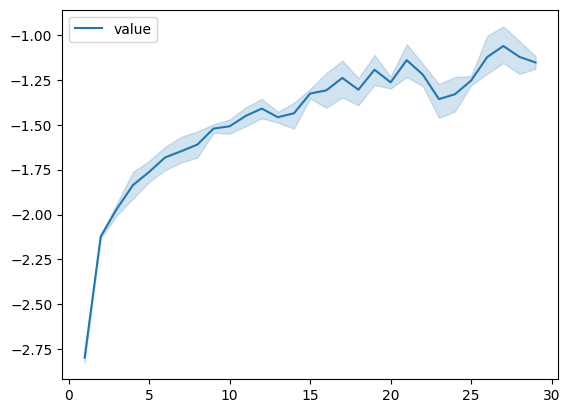

In [41]:
robustness_cols = stack_columns(dfs, "value")
ax = sb.lineplot(data=robustness_cols)

## PPO with Specification Rewards and no +x rewards

In [27]:
query = 'run.experiment == "proj2-ppo-with-spec-no-forward" and metric.name == "eval/episode_robustness"'

dfs = []

# Convert results into pandas dataframe
for run_metrics_col in repo.query_metrics(query).iter_runs():
    df = run_metrics_col.dataframe(only_last=False, include_run=False)
    if df is not None:
        dfs.append(df)
        # display(df.value)

100% 82/82 [00:00<00:00, 627.58it/s]


In [30]:
robustness_cols

,value,value,value
0,-3.080169,-3.088458,-3.133463
1,-0.617292,-0.662224,-0.635249
2,-0.628243,-0.608660,-0.613961
3,-0.575037,-0.622679,-0.571571
4,-0.557550,-0.598696,-0.579039
5,-0.618358,-0.610716,-0.580789
6,-0.545638,-0.557603,-0.594481
7,-0.587184,-0.591671,-0.576341
8,-0.590163,-0.597341,-0.585975
9,-0.595478,-0.583906,-0.581572


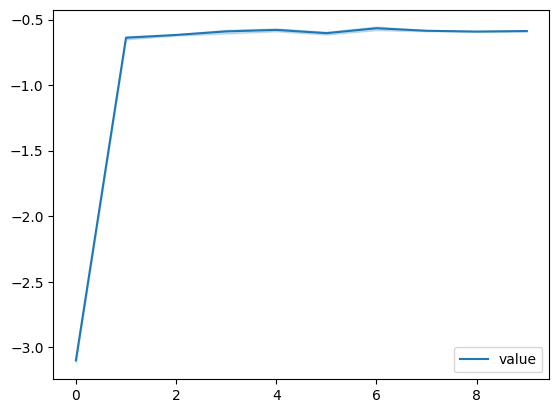

In [29]:
robustness_cols = stack_columns(dfs, "value")
ax = sb.lineplot(data=robustness_cols)

## Comparing DSCRL with Specification Rewards

In [ ]:
query = 'run.experiment == "proj2-ppo-with-spec-no-forward" and metric.name == "eval/episode_robustness"'

dfs = []

# Convert results into pandas dataframe
for run_metrics_col in repo.query_metrics(query).iter_runs():
    df = run_metrics_col.dataframe(only_last=False, include_run=False)
    if df is not None:
        dfs.append(df)
        # display(df.value)

## Old Plots

In [ ]:
query = 'run.hash in ["09316a37ebdb400b926ad00e","28e5894ef28f4fd3a6bc0cb3","2eeca304660a4ea7acfee000","b9cd3b375fa84b158d5c8eb4","ae15e6b4558e45d5aff3e761","059901cb7879451b8b232e83","5277fcd5cce843eca0a5cef1","bdd3fa9e3f4740a6ba649a56","78de90e8e6a249d7b4a478ac","52ebf197399644cba97adcdf","92126dabd70b41038633e62c","fe52d12a24a842f7aa0de17b","178b47f6251d4ecab71c3502","f2243c0453b24344ac2b6582","433c6c8581c74deba9126f9b","a054628b0b2b47ca80c3c605","c278537bf34345749af45687","3982a7b68ad04fb0a6ca5e97","def5fd83103045f593faacd2","65a3501be5a6485db1ff809d","87b19d1d04204fa0a2125642","69afadca7fdb4c35906be4bc","20b893da043b4d92bb68cd8e"] and metric.name == "eval/episode_robustness"'

In [ ]:
ppo_reward_cols = stack_columns(ppo_dfs, "eval/episode_reward")

In [ ]:
ppo_stacked_reward_df = pd.concat([ppo_dfs[i]["eval/episode_reward"][1:].astype(float) for i in range(1, 5)], axis=1)
ppo_stacked_reward_df

<Axes: >

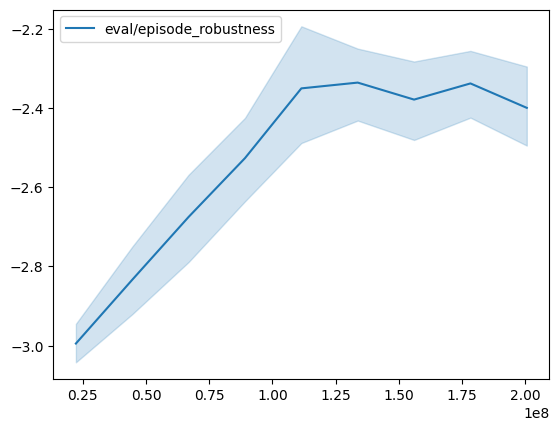

In [42]:
dscrl_robustness_cols = stack_columns(dscrl_dfs, "eval/episode_robustness")
dscrl_robustness_cols
sb.lineplot(data=dscrl_robustness_cols)

<Axes: >

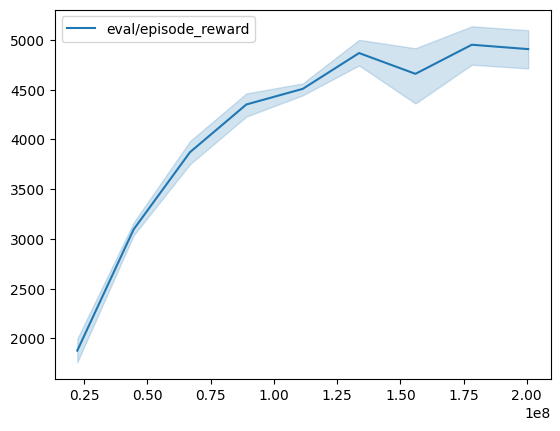

In [45]:
dscrl_reward_cols = stack_columns(dscrl_dfs, "eval/episode_reward")
dscrl_reward_cols
sb.lineplot(data=dscrl_reward_cols)

<Axes: >

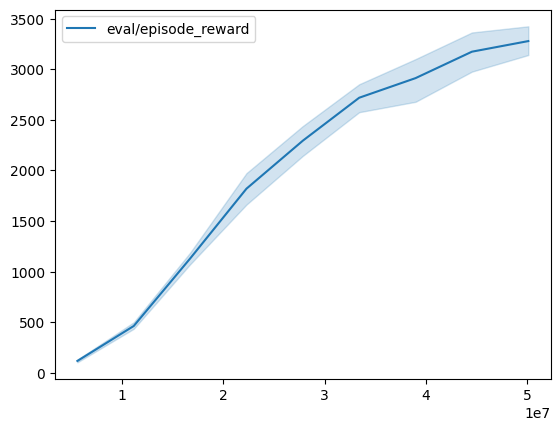

In [74]:
sb.lineplot(data=ppo_stacked_reward_df)

In [ ]:
ppo_dfs[2]

In [43]:
import numpy as np
stacked_rhos = np.stack([dscrl_dfs[i]["eval/episode_robustness"][1:].astype(float).values for i in range(1, 5)])

array([0.3235376 , 0.28964373, 0.30127877, 0.30192887, 0.30027927,
       0.29673601, 0.28510986, 0.27272451, 0.26550546])

In [62]:
# stacked_rhos.mean(axis=0)

# stacked_rhos_df = pd.DataFrame(stacked_rhos)
stacked_rhos_df = pd.concat([dscrl_dfs[i]["eval/episode_robustness"][1:].astype(float) for i in range(1, 5)], axis=1)
#stacked_rhos_df = stacked_rhos_df.reset_index(names="timesteps")
stacked_rhos_df

,eval/episode_robustness,eval/episode_robustness,eval/episode_robustness,eval/episode_robustness
5570560,0.323969,0.320445,0.328287,0.321449
11141120,0.294844,0.289531,0.293048,0.281152
16711680,0.301107,0.297324,0.312667,0.294018
22282240,0.293684,0.286127,0.322109,0.305796
27852800,0.276426,0.277469,0.319472,0.327749
33423360,0.266103,0.269162,0.317470,0.334210
38993920,0.251890,0.264955,0.304999,0.318595
44564480,0.228068,0.251262,0.293618,0.317951
50135040,0.215680,0.239677,0.287422,0.319243


In [63]:
stacked_rhos_df.head()


,eval/episode_robustness,eval/episode_robustness,eval/episode_robustness,eval/episode_robustness
5570560,0.323969,0.320445,0.328287,0.321449
11141120,0.294844,0.289531,0.293048,0.281152
16711680,0.301107,0.297324,0.312667,0.294018
22282240,0.293684,0.286127,0.322109,0.305796
27852800,0.276426,0.277469,0.319472,0.327749


Text(0.5, 0, 'timesteps')

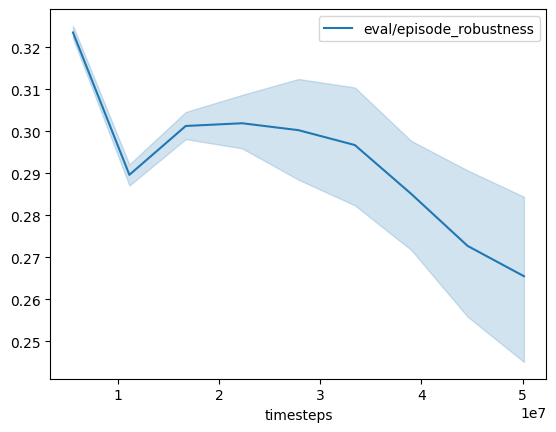

In [70]:
ax = sb.lineplot(data=stacked_rhos_df)
ax.set_xlabel("timesteps")

In [65]:
stacked_reward_df = pd.concat([dscrl_dfs[i]["eval/episode_reward"][1:].astype(float) for i in range(1, 5)], axis=1)
stacked_reward_df

,eval/episode_reward,eval/episode_reward,eval/episode_reward,eval/episode_reward
5570560,116.415878,140.420746,101.707825,103.423035
11141120,419.237457,472.448059,529.364807,374.440613
16711680,984.487061,1105.554932,834.572327,1073.442383
22282240,1892.635986,1987.755127,1456.529785,1756.829834
27852800,2206.142090,2453.418701,1829.139404,2520.385742
33423360,2928.383057,2770.024658,1929.486572,2954.229004
38993920,3234.015625,3038.151855,2184.994141,3275.265137
44564480,3079.635254,3298.819336,2712.125000,3084.580811
50135040,3428.739746,3012.038574,2966.310303,3732.254883


<Axes: >

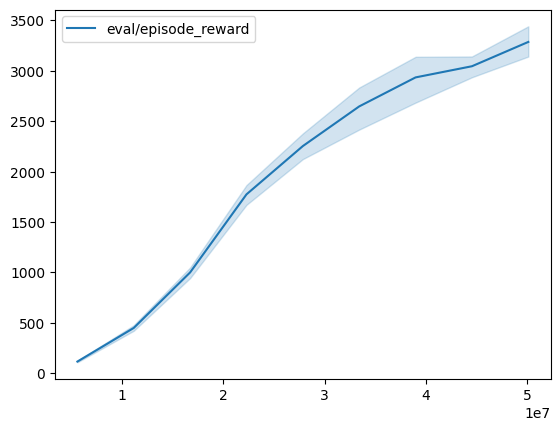

In [67]:
sb.lineplot(data=stacked_reward_df)

# Testing Value Gradients

In [159]:
rng = jax.random.PRNGKey(0)

In [160]:
# from brax.training import acting

# policy = make_policy(params)

# end_state, data = acting.generate_unroll(
#     env,
#     state,
#     policy,
#     rng,
#     16,
# )

In [161]:
# Learning simple model and optimizing policy using stl gradient computed through the model

# end_state.obs.shape

# data.next_observation[-2] == data.observation[-1]

# Focus only on STL rewards / gradients

In [162]:
# type(rollout[2])

In [ ]:
state = rollout[0]

action, info = jit_inference_fn(state.obs, rng)
nstate = jit_step(state, action)
nstate